In [108]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as scpo
import shapely as sply

In [109]:
data = gpd.read_file('./data/landkreise_merged_i.geojson')
data = data.set_index('name')

In [110]:
bundeslaender = data[data.art == 'bundesland']
landkreise = data[data.art == 'landkreis']
dateColNames = landkreise.columns[4:-2]
landkreise[dateColNames] = landkreise[dateColNames].astype(np.int64)
bundeslaender[dateColNames] = landkreise.groupby('partof')[dateColNames].sum()
landkreise.current = landkreise.current.astype(np.int64)
bundeslaender.current = landkreise.groupby('partof').current.sum()
landkreise[dateColNames] = landkreise[dateColNames].div(landkreise['population'], axis='rows') * 10000

In [111]:
landkreiseBayern = landkreise[landkreise.partof == 'Bayern']

In [112]:
lks = landkreiseBayern.index
centroids = landkreiseBayern.centroid
connectivity = np.zeros((len(lks), len(lks)))
for x in range(len(lks)):
    for y in range(x, len(lks)):
        lk1 = landkreiseBayern.index[x]
        lk2 = landkreiseBayern.index[y]
        c = 1.0 / ( centroids[lk1].distance(centroids[lk2]) + 1)
        connectivity[x, y] = c
        connectivity[y, x] = c

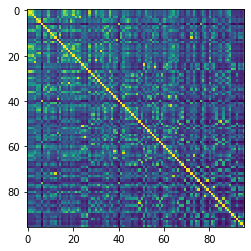

In [113]:
plt.imshow(connectivity)

In [114]:
def model(time, alpha, beta):
    T = len(time)
    incubTime = 7
    lks = landkreiseBayern.index
    landkreisIds = np.arange(len(lks))
    infected = np.zeros((len(landkreisIds), T))
    infected[:, 0] = landkreiseBayern[dateColNames[0]].values
    Ks = landkreiseBayern['population'].values * 0.7
    for t in range(T-1):
        for landkreis in landkreisIds:
            K = Ks[landkreis]
            localChange = infected[landkreis, t] * (1 - infected[landkreis, t] / K)
            spatialChange = np.inner( connectivity[landkreis, :], infected[:, t-incubTime] )
            dndt = alpha * localChange + beta * spatialChange
            infected[landkreis, t+1] = infected[landkreis, t] + dndt
    return infected

In [115]:
def me(paras):
    alpha, beta = paras
    time = np.arange(len(dateColNames))
    y = landkreiseBayern[dateColNames].values
    y_sim = model(time, alpha, beta)
    me = np.mean(np.sqrt((y - y_sim) * (y - y_sim)))
    return me

In [116]:
results = scpo.minimize(me, [0.2, 0.001], bounds=[(0.0, 2.0), (0.0, 2.0)])
results

      fun: 1.666683274446395
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0541637 ,  0.29243203])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 132
      nit: 19
   status: 0
  success: True
        x: array([0.10887269, 0.0165737 ])

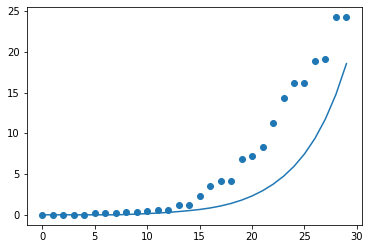

In [117]:
alpha, beta = results.x
time = np.arange(len(dateColNames))
y_sim = model(time, alpha, beta)
y = landkreiseBayern[dateColNames].values
i = 8
plt.scatter(time, y[i])
plt.plot(time, y_sim[i])

In [118]:
def model2(time, alpha1, beta1, alpha2, beta2):
    T = len(time)
    incubTime = 7
    t_measure = list(dateColNames.values).index('22.03.2020') + incubTime
    lks = landkreiseBayern.index
    landkreisIds = np.arange(len(lks))
    infected = np.zeros((len(landkreisIds), T))
    infected[:, 0] = landkreiseBayern[dateColNames[0]].values
    Ks = landkreiseBayern['population'].values * 0.7
    for t in range(T-1):
        alpha = alpha1 if t < t_measure else alpha2
        beta = beta1 if t < t_measure else beta2
        for landkreis in landkreisIds:
            K = Ks[landkreis]
            localChange = infected[landkreis, t] * (1 - infected[landkreis, t] / K)
            spatialChange = np.inner( connectivity[landkreis, :], infected[:, t-incubTime] )
            dndt = alpha * localChange + beta * spatialChange
            infected[landkreis, t+1] = infected[landkreis, t] + dndt
    return infected

In [119]:
def me2(paras):
    alpha1, beta1, alpha2, beta2 = paras
    time = np.arange(len(dateColNames))
    y = landkreiseBayern[dateColNames].values
    y_sim = model2(time, alpha1, beta1, alpha2, beta2)
    me = np.mean(np.sqrt((y - y_sim) * (y - y_sim)))
    return me

In [120]:
results = scpo.minimize(me2, [0.3, 0.005, 0.1, 0.001], bounds=[(0.0, 2.0), (0.0, 2.0), (0.0, 2.0), (0.0, 2.0)])
results

      fun: 1.5154781391888283
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.03923477,  0.08303775, -0.02433258, -0.03383249])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 385
      nit: 27
   status: 0
  success: True
        x: array([0.11347915, 0.02071949, 0.03740152, 0.00070121])

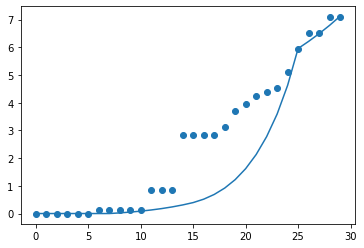

In [126]:
alpha1, beta1, alpha2, beta2 = results.x
time = np.arange(len(dateColNames))
y_sim = model2(time, alpha1, beta1, alpha2, beta2)
y = landkreiseBayern[dateColNames].values
i = 6
plt.scatter(time, y[i])
plt.plot(time, y_sim[i])

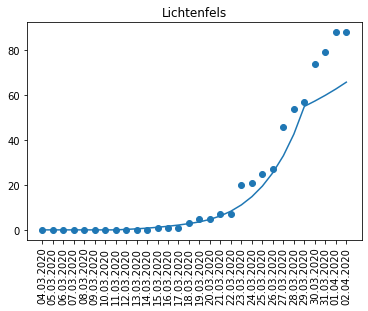

In [145]:
def plotSim(lkName, results):
    alpha1, beta1, alpha2, beta2 = results.x
    time = np.arange(len(dateColNames))
    population = landkreiseBayern.loc[lkName, 'population']
    y_sim = model2(time, alpha1, beta1, alpha2, beta2)
    y_sim = y_sim * population / 10000
    y = landkreiseBayern[dateColNames].values
    y = y * population / 10000
    i = list(landkreiseBayern.index).index(lkName)
    plt.scatter(time, y[i])
    plt.plot(time, y_sim[i])
    plt.title(lkName)
    plt.xticks(range(len(dateColNames)), dateColNames.values, rotation=90)

plotSim('Lichtenfels', results)

In [142]:
landkreiseBayern.index

Index(['Fürth (Stadt)', 'Erlangen (Stadt)', 'Nürnberg (Stadt)',
       'Bayreuth (Landkreis)', 'Pfaffenhofen an der Ilm', 'Ingolstadt',
       'Aschaffenburg (Stadt)', 'Freising', 'Dachau', 'Nürnberger Land',
       'Ebersberg', 'München (Landkreis)', 'Rosenheim (Stadt)',
       'Hof (Landkreis)', 'München (Stadt)', 'Lichtenfels',
       'Fürth (Landkreis)', 'Roth', 'Coburg (Stadt)', 'Eichstätt', 'Schwabach',
       'Kulmbach', 'Bamberg (Landkreis)', 'Bayreuth (Stadt)', 'Straubing',
       'Regensburg (Stadt)', 'Deggendorf', 'Erlangen-Höchstadt', 'Memmingen',
       'Günzburg', 'Bamberg (Stadt)', 'Dillingen an der Donau',
       'Coburg (Landkreis)', 'Neumarkt in der Oberpfalz', 'Fürstenfeldbruck',
       'Erding', 'Forchheim', 'Augsburg (Stadt)', 'Weiden in der Oberpfalz',
       'Hof (Stadt)', 'Aschaffenburg (Landkreis)', 'Miesbach', 'Amberg',
       'Aichach-Friedberg', 'Neuburg-Schrobenhausen', 'Starnberg', 'Neu-Ulm',
       'Garmisch-Partenkirchen', 'Augsburg (Landkreis)', 'Schwei